<a href="https://colab.research.google.com/github/ravichandranNa/AJ_ML_Library/blob/master/AVDemandHack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm
from sklearn.model_selection import train_test_split


In [ ]:
demand_train = pd.read_csv('/content/drive/My Drive/demand forecasting/train_0irEZ2H.csv')
demand_test = pd.read_csv('/content/drive/My Drive/demand forecasting/test_nfaJ3J5.csv')

In [ ]:
demand_test.set_index('record_ID',inplace=True)
demand_train.set_index('record_ID',inplace=True)

In [ ]:
demand_test['week'] = pd.to_datetime(demand_test['week'])
demand_train['week'] = pd.to_datetime(demand_train['week'])

In [ ]:
def convert_dates(x):
    x['date']=pd.to_datetime(x['week'])
    x['month']=x['week'].dt.month
    x['year']=x['week'].dt.year
    x['dayofweek']=x['week'].dt.dayofweek
    x.pop('week')
    return x

In [ ]:
df = convert_dates(demand_train)
df_test = convert_dates(demand_test)

In [ ]:
demand_test.drop('date',axis=1,inplace=True)
demand_train.drop('date',axis=1,inplace=True)

In [ ]:
# def add_avg(x):
#     x['daily_avg']=x.groupby(['sku_id','store_id','dayofweek'])['units_sold'].transform('mean')
#     x['monthly_avg']=x.groupby(['sku_id','store_id','month'])['units_sold'].transform('mean')
#     return x
# df = add_avg(df)


In [ ]:
df.head(2)

,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold,month,year,dayofweek
record_ID,,,,,,,,,,
1,8091,216418,99.0375,111.8625,0,0,20,1,2011,0
2,8091,216419,99.0375,99.0375,0,0,28,1,2011,0


In [ ]:
# daily_avg = df.groupby(['sku_id','store_id','dayofweek'])['units_sold'].mean().reset_index()
# monthly_avg = df.groupby(['sku_id','store_id','month'])['units_sold'].mean().reset_index()

In [ ]:
# def merge(x,y,col,col_name):
#     x =pd.merge(x, y, how='left', on=None, left_on=col, right_on=col,
#             left_index=False, right_index=False, sort=True,
#              copy=True, indicator=False,validate=None)
#     x=x.rename(columns={'units_sold':col_name})
#     return x
# df_test=merge(df_test, daily_avg,['sku_id','store_id','dayofweek'],'daily_avg')
# df_test=merge(df_test, monthly_avg,['sku_id','store_id','month'],'monthly_avg')

In [ ]:
demand_train['total_price'] = np.log(demand_train['total_price']+10)
demand_train['base_price'] = np.log(demand_train['base_price']+10)
demand_train['units_sold'] = np.log(demand_train['units_sold']+10)
demand_test['total_price'] = np.log(demand_test['total_price']+10)
demand_test['base_price'] = np.log(demand_test['base_price']+10)

In [ ]:
df_test.head(2)

,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,month,year,dayofweek
record_ID,,,,,,,,,
212645,8091,216418,4.773224,4.773224,0,0,7,2013,1
212646,8091,216419,4.779229,4.779229,0,0,7,2013,1


In [ ]:
x_train,x_test,y_train,y_test = train_test_split(df.drop('units_sold',axis=1),df.pop('units_sold'),random_state=123,test_size=0.2)

In [ ]:
import xgboost as xgb
def XGBmodel(x_train,x_test,y_train,y_test):
    matrix_train = xgb.DMatrix(x_train,label=y_train)
    matrix_test = xgb.DMatrix(x_test,label=y_test)
    model=xgb.train(params={'objective':'reg:linear','eval_metric':'mae'}
                    ,dtrain=matrix_train,num_boost_round=500, 
                    early_stopping_rounds=20,evals=[(matrix_test,'test')],)
    return model

model=XGBmodel(x_train,x_test,y_train,y_test)

[06:43:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	test-mae:2.35805
Will train until test-mae hasn't improved in 20 rounds.
[1]	test-mae:1.65141
[2]	test-mae:1.15781
[3]	test-mae:0.824955
[4]	test-mae:0.615932
[5]	test-mae:0.49135
[6]	test-mae:0.419509
[7]	test-mae:0.381011
[8]	test-mae:0.350805
[9]	test-mae:0.336364
[10]	test-mae:0.326935
[11]	test-mae:0.321178
[12]	test-mae:0.311766
[13]	test-mae:0.307996
[14]	test-mae:0.303241
[15]	test-mae:0.300346
[16]	test-mae:0.296833
[17]	test-mae:0.291063
[18]	test-mae:0.290084
[19]	test-mae:0.288216
[20]	test-mae:0.286157
[21]	test-mae:0.28466
[22]	test-mae:0.279992
[23]	test-mae:0.27886
[24]	test-mae:0.275945
[25]	test-mae:0.274803
[26]	test-mae:0.271476
[27]	test-mae:0.270596
[28]	test-mae:0.269711
[29]	test-mae:0.268391
[30]	test-mae:0.265494
[31]	test-mae:0.263538
[32]	test-mae:0.261915
[33]	test-mae:0.261098
[34]	test-mae:0.259277
[35]	test-mae:0.258601
[36]	

In [ ]:
y_pred = model.predict(xgb.DMatrix(df_test), ntree_limit = model.best_ntree_limit)
submission = pd.DataFrame(index=demand_test.index)

submission['units_sold']= np.exp(y_pred).round()

submission.to_csv('submission2.csv',index=False)

In [ ]:
submission.head(7)

,units_sold
record_ID,
212645,30.0
212646,31.0
212647,33.0
212648,37.0
212649,31.0
212653,35.0
212654,47.0


In [ ]:
demand_train.head(2)

,record_ID,week,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold
0,1,17/01/11,8091,216418,99.0375,111.8625,0,0,20
1,2,17/01/11,8091,216419,99.0375,99.0375,0,0,28


In [ ]:
demand_test.head(2)

,record_ID,week,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku
0,212645,16/07/13,8091,216418,108.3000,108.3000,0,0
1,212646,16/07/13,8091,216419,109.0125,109.0125,0,0


In [ ]:
# Skewness and Kurtosis
print("Skewness : %f" % demand_train['units_sold'].skew())
print("Kurtosis : %f" % demand_train['units_sold'].kurt())

Skewness : 6.114996
Kurtosis : 93.686253


In [ ]:
numeric_features = demand_train.select_dtypes(include=[np.number])
numeric_features.dtypes

store_id             int64
sku_id               int64
total_price        float64
base_price         float64
is_featured_sku      int64
is_display_sku       int64
units_sold           int64
dtype: object

In [ ]:
demand_train['store_id'] = demand_train['store_id'].astype(object)
demand_train['sku_id'] = demand_train['sku_id'].astype(object)

In [ ]:
print(demand_train.describe(include=['number']).loc[['min','max','mean']].T.sort_values('max'))

                    min        max        mean
is_featured_sku   0.000     1.0000    0.095611
is_display_sku    0.000     1.0000    0.133200
total_price      41.325   562.1625  206.626751
base_price       61.275   562.1625  219.425927
units_sold        1.000  2876.0000   51.674206


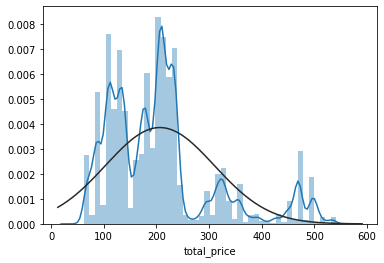

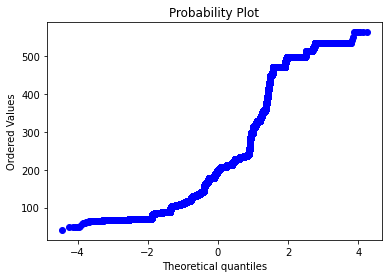

In [ ]:
# Histogram and normal probability plot
sns.distplot(demand_train['total_price'], fit = norm)
fig = plt.figure()
res = stats.probplot(demand_train['total_price'],plot = plt)

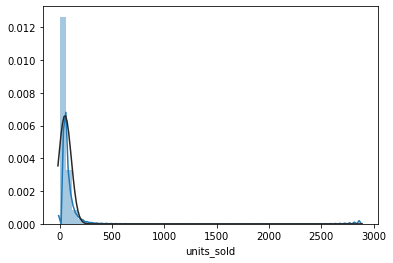

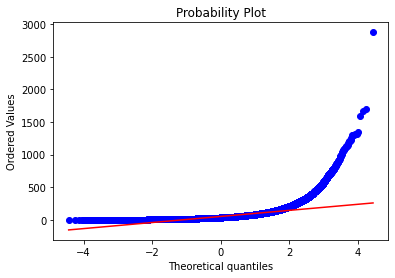

In [ ]:
# Histogram and normal probability plot
sns.distplot(demand_train['units_sold'], fit = norm)
fig = plt.figure()
res = stats.probplot(demand_train['units_sold'],plot = plt)

In [ ]:
demand_train['total_price'] = np.log(demand_train['total_price']+10)
demand_train['units_sold'] = np.log(demand_train['units_sold']+10)
demand_test['total_price'] = np.log(demand_test['total_price']+10)


In [ ]:
demand_train.head(2)

,week,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold
record_ID,,,,,,,,
1,17/01/11,8091,216418,4.691692,111.8625,0,0,3.401197
2,17/01/11,8091,216419,4.691692,99.0375,0,0,3.637586


In [ ]:
demand_test.drop('base_price',axis=1,inplace=True)
demand_train.drop('base_price',axis=1,inplace=True)


In [ ]:
from sklearn.model_selection import train_test_split
def split_data(train_data,test_data):
    train_data['week'] = pd.to_datetime(train_data['week'])
    test_data['week'] = pd.to_datetime(test_data['week'])

    train_data['month'] = train_data['week'].dt.month
    train_data['day'] = train_data['week'].dt.dayofweek
    train_data['year'] = train_data['week'].dt.year

    test_data['month'] = test_data['week'].dt.month
    test_data['day'] = test_data['week'].dt.dayofweek
    test_data['year'] = test_data['week'].dt.year
          

    col = [i for i in test_data.columns if i not in ['week']]
    y = 'units_sold'
 
    demand_train.dropna(inplace=True) 
    train_x, test_x, train_y, test_y = train_test_split(train_data[col],train_data[y], test_size=0.2, random_state=2018)
    return (train_x, test_x, train_y, test_y,col)

train_x, test_x, train_y, test_y,col = split_data(demand_train,demand_test)

In [ ]:
demand_test.drop('week',inplace=True,axis=1)
demand_train.drop('week',inplace=True,axis=1) 

In [ ]:
demand_train.head(2)

,store_id,sku_id,total_price,is_featured_sku,is_display_sku,units_sold,month,day,year
record_ID,,,,,,,,,
1,8091,216418,4.691692,0,0,3.401197,1,0,2011
2,8091,216419,4.691692,0,0,3.637586,1,0,2011


In [ ]:
demand_train.drop('year',inplace=True,axis=1)
demand_test.drop('year',inplace=True,axis=1)

In [ ]:
demand_test.head(2)

,store_id,sku_id,total_price,is_featured_sku,is_display_sku,month,day
record_ID,,,,,,,
212645,8091,216418,4.773224,0,0,7,1
212646,8091,216419,4.779229,0,0,7,1


In [ ]:
from sklearn.preprocessing import LabelEncoder
# instantiate labelencoder object
le = LabelEncoder()

In [ ]:
demand_test[['store_id','sku_id']] = demand_test[['store_id','sku_id']].apply(lambda col: le.fit_transform(col))
demand_test.head(2)

,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,month,year,dayofweek
record_ID,,,,,,,,,
212645,3,1,4.773224,4.773224,0,0,7,2013,1
212646,3,2,4.779229,4.779229,0,0,7,2013,1


In [ ]:

demand_train[['store_id','sku_id']] = demand_train[['store_id','sku_id']].apply(lambda col: le.fit_transform(col))
demand_train.head(2)

,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold,month,year,dayofweek
record_ID,,,,,,,,,,
1,3,1,4.691692,4.802893,0,0,3.401197,1,2011,0
2,3,2,4.691692,4.691692,0,0,3.637586,1,2011,0


In [ ]:
demand_test.head(2)

,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,month,year,dayofweek
record_ID,,,,,,,,,
212645,3,1,4.773224,4.773224,0,0,7,2013,1
212646,3,2,4.779229,4.779229,0,0,7,2013,1


In [ ]:
def spliting_data(train_data,test_data):
         

    col = [i for i in test_data.columns if i not in ['week']]
    y = 'units_sold'
 
    demand_train.dropna(inplace=True) 
    train_x, test_x, train_y, test_y = train_test_split(df.drop('units_sold',axis=1),df.pop('units_sold'),random_state=123,test_size=0.2)
    return (train_x, test_x, train_y, test_y,col)


train_x, test_x, train_y, test_y,col = spliting_data(demand_train,demand_test)

In [ ]:
train_x.shape,train_y.shape,test_x.shape

((120119, 9), (120119,), (30030, 9))

In [ ]:

import lightgbm as lgb
def model(train_x,train_y,test_x,test_y,col):
    params = {
        'nthread': 10,
         'max_depth': 5,
#         'max_depth': 9,
        'task': 'train',
        'boosting_type': 'gbdt',
        'objective': 'regression_l1',
        'metric': 'mape', # this is abs(a-e)/max(1,a)
#         'num_leaves': 39,
        'num_leaves':70,
        'learning_rate': 0.2,
       'feature_fraction': 0.9,
#         'feature_fraction': 0.8108472661400657,
#         'bagging_fraction': 0.9837558288375402,
       'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'lambda_l1': 3.097758978478437,
        'lambda_l2': 2.9482537987198496,
#       'lambda_l1': 0.06,
#       'lambda_l2': 0.1,
        'verbose': 1,
        'min_child_weight': 6.996211413900573,
        'min_split_gain': 0.037310344962162616,
        }
    
    lgb_train = lgb.Dataset(train_x,train_y)
    lgb_valid = lgb.Dataset(test_x,test_y)
    model = lgb.train(params, lgb_train, 10000, valid_sets=[lgb_train, lgb_valid],early_stopping_rounds=50, verbose_eval=500)
    y_test = model.predict(demand_test[col])
    return y_test,model

In [ ]:
%%time
y_test, model = model(train_x,train_y,test_x,test_y,col)

Training until validation scores don't improve for 50 rounds.
[500]	training's mape: 0.0549339	valid_1's mape: 0.0580641
[1000]	training's mape: 0.05139	valid_1's mape: 0.0558775
[1500]	training's mape: 0.0496463	valid_1's mape: 0.0551505
[2000]	training's mape: 0.048487	valid_1's mape: 0.0546917
[2500]	training's mape: 0.0476559	valid_1's mape: 0.0544229
[3000]	training's mape: 0.0469883	valid_1's mape: 0.0541941
[3500]	training's mape: 0.0464093	valid_1's mape: 0.0540032
[4000]	training's mape: 0.0459263	valid_1's mape: 0.0538791
[4500]	training's mape: 0.0455325	valid_1's mape: 0.0537726
Early stopping, best iteration is:
[4453]	training's mape: 0.0455691	valid_1's mape: 0.0537714
CPU times: user 3min 13s, sys: 33.8 s, total: 3min 47s
Wall time: 2min 10s


In [ ]:
sample_df = pd.DataFrame(index=demand_test.index)
sample_df['sales'] = np.exp(y_test).round()
sample_df.to_csv('dm_lgb_bayasian_params.csv', index=False)
sample_df['sales'].head()

record_ID
212645    34.0
212646    32.0
212647    31.0
212648    39.0
212649    36.0
Name: sales, dtype: float64

In [ ]:
from sklearn.linear_model import LinearRegression,Ridge,Lasso,RidgeCV
from sklearn.ensemble import RandomForestRegressor,BaggingRegressor,GradientBoostingRegressor,AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error,mean_squared_error, r2_score,mean_absolute_error # for regression

In [ ]:
X = demand_train.drop('units_sold',axis=1)
y = demand_train['units_sold']

In [ ]:
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=42)

In [ ]:
# models=[RandomForestRegressor(),AdaBoostRegressor(),BaggingRegressor(),SVR(),KNeighborsRegressor()]
# model_names=['RandomForestRegressor','AdaBoostRegressor','BaggingRegressor','SVR','KNeighborsRegressor']
# rmsle=[]
# d={}
# for model in range (len(models)):
#     clf=models[model]
#     clf.fit(train_x,train_y)
#     test_pred=clf.predict(test_x)
#     rmsle.append(np.sqrt(mean_squared_log_error(test_pred,test_y)))
# d={'Modelling Algo':model_names,'RMSLE':rmsle}   
d

NameError: ignored

In [ ]:
X_train,y_train,X_test,y_test = train_x,train_y,test_x,test_y

In [ ]:

from sklearn import linear_model
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X_train, y_train)

# Make predictions using the testing set
y_pred = regr.predict(X_test)
print('The accuracy of the Linear Regression is',r2_score(y_test,y_pred))
print ('RMSE is: \n', mean_squared_error(y_test, y_pred))
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X_train, y_train)

# Make predictions using the testing set
y_pred = regr.predict(X_test)
print('The accuracy of the Linear Regression is',r2_score(y_test,y_pred))
print ('RMSE is: \n', mean_squared_error(y_test, y_pred))
print(np.sqrt(mean_squared_log_error(y_test, y_pred)))

The accuracy of the Linear Regression is 0.2883411836290274
RMSE is: 
 0.31788158837901465
The accuracy of the Linear Regression is 0.2883411836290274
RMSE is: 
 0.31788158837901465
0.1146202051835265


In [ ]:
y_pred = regr.predict(demand_test)

In [ ]:
sample_df = pd.DataFrame(index=demand_test.index)
sample_df['sales'] = np.exp(y_pred).round()
sample_df.to_csv('reg.csv', index=False)
sample_df['sales'].head()

record_ID
212645    60.0
212646    59.0
212647    55.0
212648    59.0
212649    48.0
Name: sales, dtype: float64

In [ ]:
import xgboost as xgb

xg_reg = xgb.XGBRegressor(learning_rate =0.01, n_estimators=5580, 
                                     max_depth=3,min_child_weight=0 ,
                                     gamma=0, subsample=0.7,
                                     colsample_bytree=0.7,
                                     objective= 'reg:linear',nthread=4,
                                     scale_pos_weight=1,seed=27, 
                                     reg_alpha=0.00006)
xg_reg.fit(X_train,y_train)

preds = xg_reg.predict(X_test)
print('The accuracy of the xgboost is',r2_score(y_test,preds))
print ('RMSE is: \n', mean_squared_error(y_test,preds))

[14:54:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
The accuracy of the xgboost is 0.7217724091593607
RMSE is: 
 0.12427785122974622


In [ ]:
print(np.sqrt(mean_squared_log_error(y_test, preds)))

0.07373490368753463


In [ ]:
preds = xg_reg.predict(demand_test)

In [ ]:
sample_df = pd.DataFrame(index=demand_test.index)
sample_df['sales'] = np.exp(preds).round()
sample_df.to_csv('xgb.csv', index=False)
sample_df['sales'].head()

record_ID
212645    52.0
212646    41.0
212647    23.0
212648    33.0
212649    37.0
Name: sales, dtype: float32

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
gbr_model = GradientBoostingRegressor(n_estimators=4780, learning_rate=0.01,
                                   max_depth=10, max_features='sqrt',
                                   min_samples_leaf=1, min_samples_split=250, 
                                   loss='huber', random_state =6).fit(X_train,y_train)
gbr_preds = gbr_model.predict(X_test)
print('The accuracy of the Gradient boost is',r2_score(y_test,gbr_preds))
print ('RMSE is: \n', mean_squared_error(y_test,gbr_preds))
print(np.sqrt(mean_squared_log_error(y_test, gbr_preds)))

The accuracy of the Gradient boost is 0.8395742830758934
RMSE is: 
 0.0716584696761402
0.05668269344989678


In [ ]:
gbr_preds = gbr_model.predict(demand_test)

In [ ]:
sample_df = pd.DataFrame(index=demand_test.index)
sample_df['sales'] = np.exp(gbr_preds).round()
sample_df.to_csv('gbr.csv', index=False)
sample_df['sales'].head()

record_ID
212645    38.0
212646    33.0
212647    30.0
212648    35.0
212649    31.0
Name: sales, dtype: float64